# Graph figures for paper

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns

plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = 7
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = True

In [3]:
SOCKSHOP_DATASET_ID = "9n6mf"
TRAINTICKET_DATASET_ID = "m9dgg"

In [4]:
import sys
sys.path.append('../')

In [5]:
from eval.tsdr import load_tsdr_by_chaos

dataset_by_chaos = load_tsdr_by_chaos(
    dataset_id=SOCKSHOP_DATASET_ID, 
    metric_types={
        "services": True,
        "containers": True,
        "middlewares": True,
        "nodes": False,
    },
    revert_normalized_time_series=True,
    tsdr_options={
        "enable_unireducer": False,
        "enable_multireducer": False,
    },
    target_chaos_types={"pod-cpu-hog", "pod-memory-hog", "pod-network-latency"},
    use_manually_selected_metrics=False,
    # from_orig=(True, 180),
    validation_filtering=(True, 4*5)
)

In [6]:
tt_dataset_by_chaos = load_tsdr_by_chaos(
    dataset_id=TRAINTICKET_DATASET_ID, 
    metric_types={
        "services": True,
        "containers": True,
        "middlewares": True,
        "nodes": False,
    },
    revert_normalized_time_series=True,
    tsdr_options={
        "enable_unireducer": False,
        "enable_multireducer": False,
    },
    target_chaos_types={"pod-cpu-hog", "pod-memory-hog", "pod-network-latency"},
    use_manually_selected_metrics=False,
    # from_orig=(True, 180),
    validation_filtering=(True, 4*5)
)

In [31]:
import pandas as pd

record, data_df_by_metric_type = dataset_by_chaos[("pod-cpu-hog", "carts")][0]
print(record.chaos_case_full())
dataset = pd.concat([
    data_df_by_metric_type["containers"][0],
    data_df_by_metric_type["services"][0],
    data_df_by_metric_type["middlewares"][0],
], axis=1)
dataset.shape, record.chaos_case_file()

carts/pod-cpu-hog/9n6mf-3


((180, 1325),
 '2023-02-17-argowf-chaos-9n6mf-carts_pod-cpu-hog_3.json of carts/pod-cpu-hog')

In [8]:
cause_cols = [record.pk.get_container_by_metric(metric) == record.chaos_comp() for metric in dataset.columns]
cause_dataset = dataset.loc[:, cause_cols]

In [9]:
from tsdr.clustering.changepoint import detect_multi_changepoints

changepoints = detect_multi_changepoints(cause_dataset, cost_model="l2", penalty="bic")
metric_and_changepoints = list(zip(cause_dataset.columns.tolist(), changepoints))

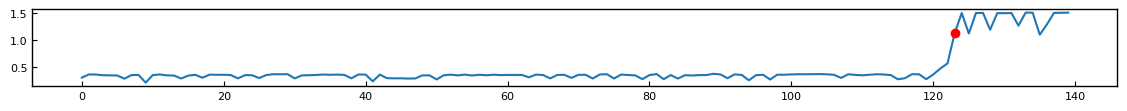

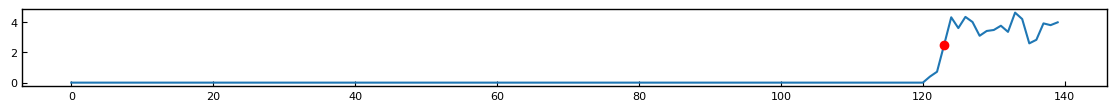

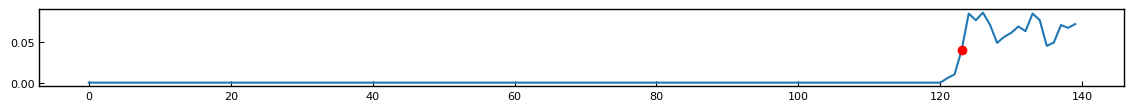

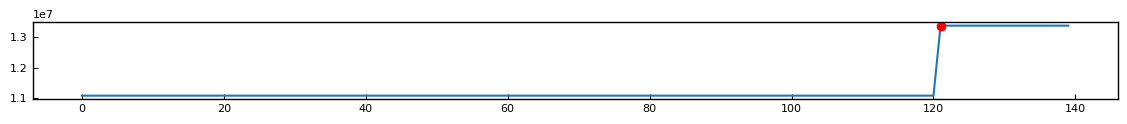

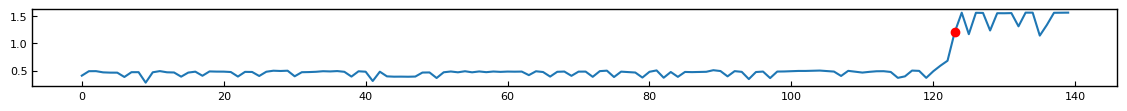

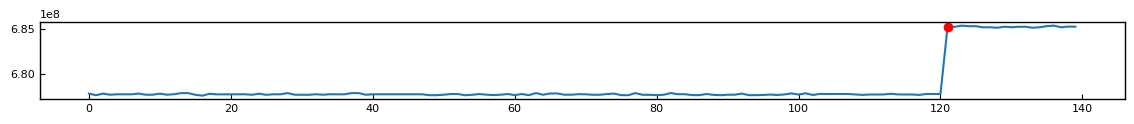

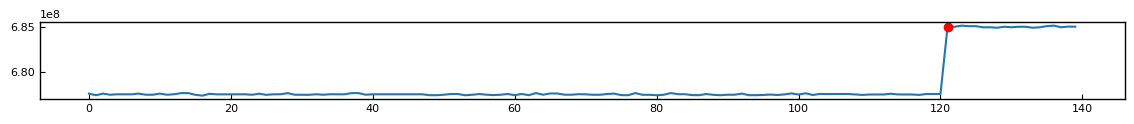

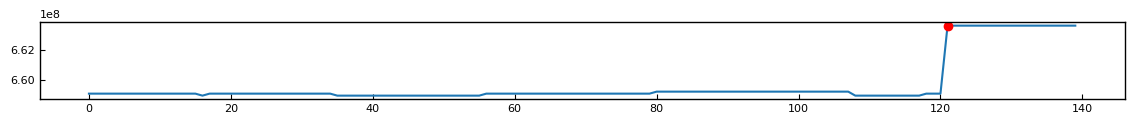

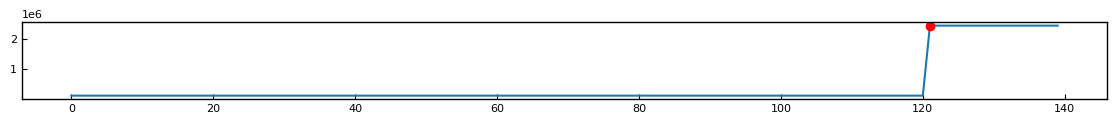

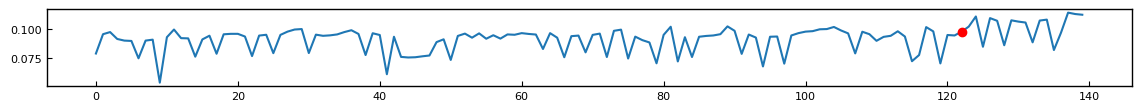

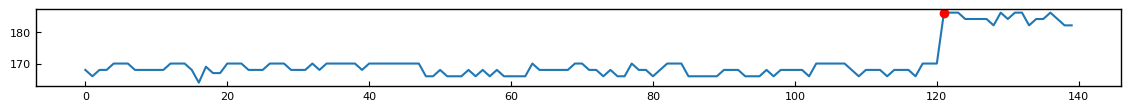

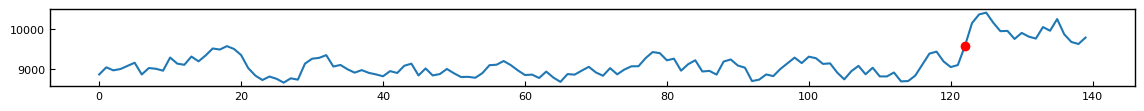

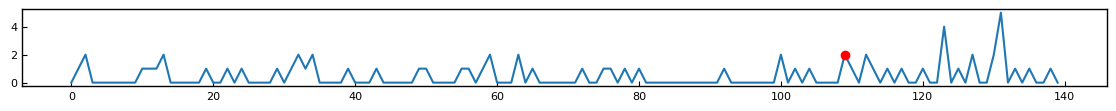

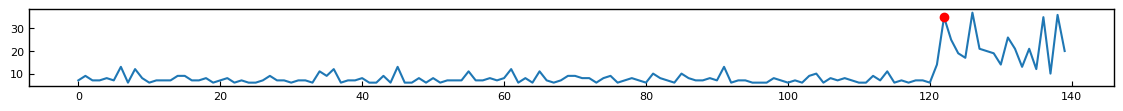

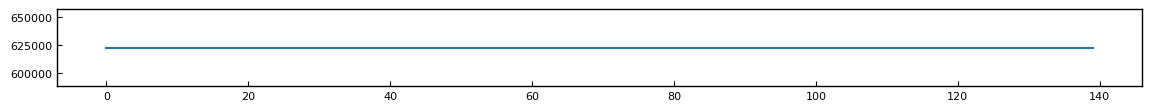

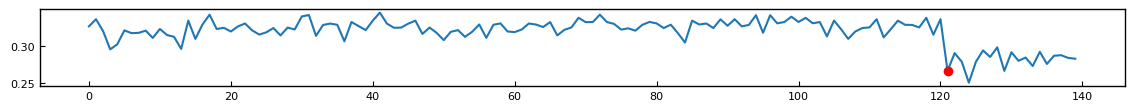

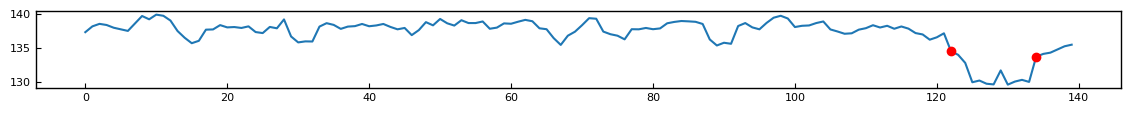

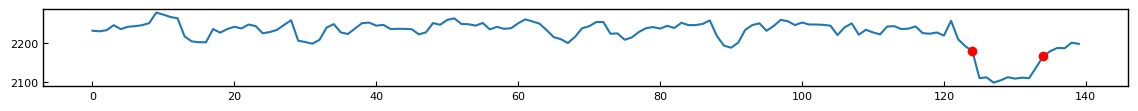

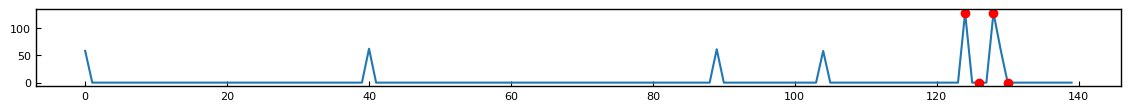

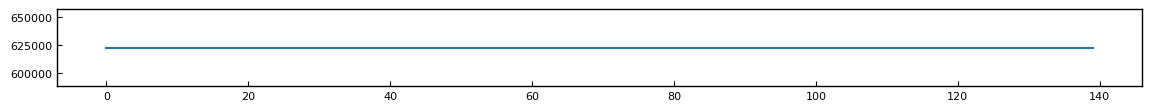

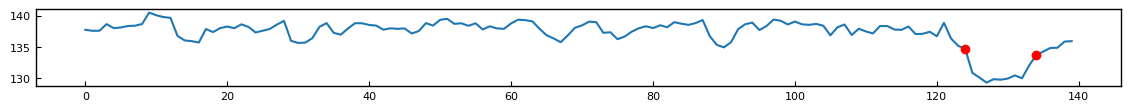

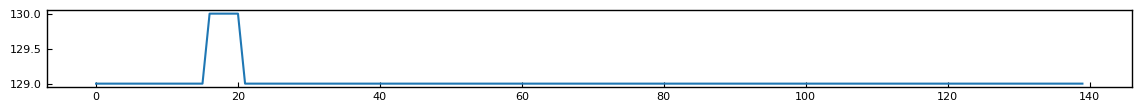

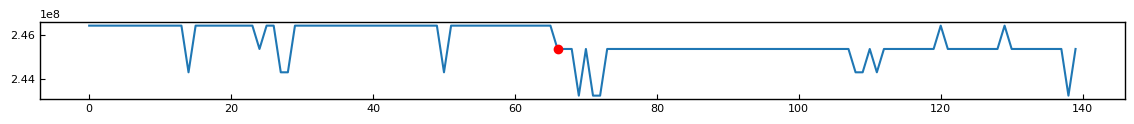

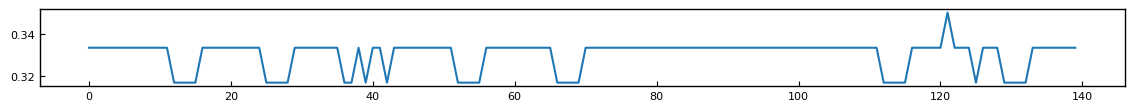

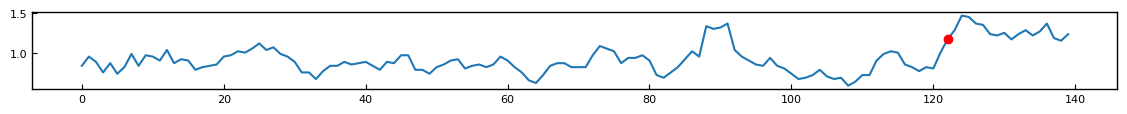

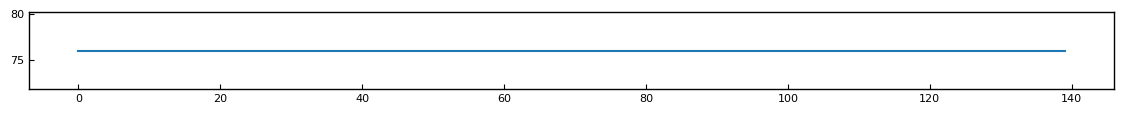

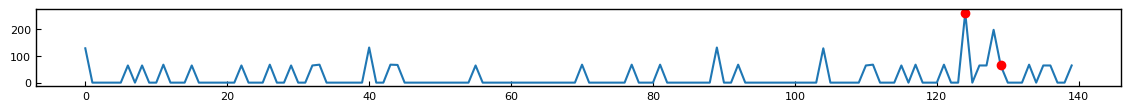

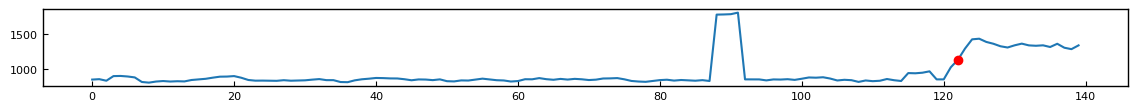

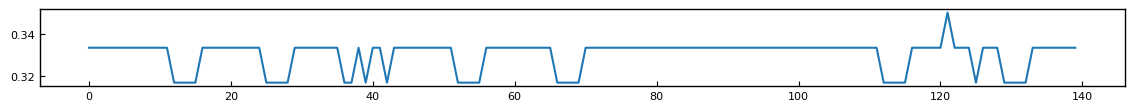

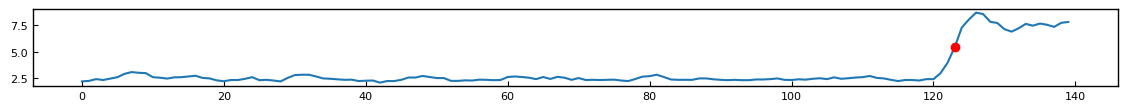

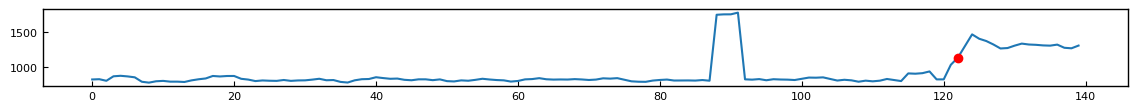

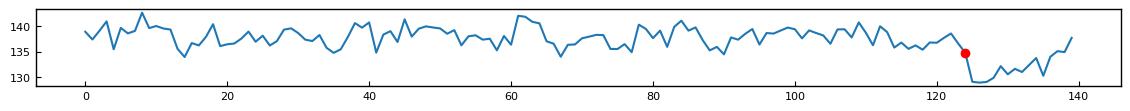

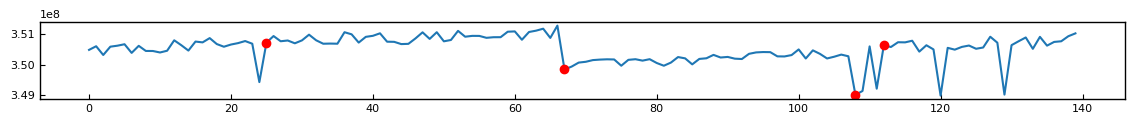

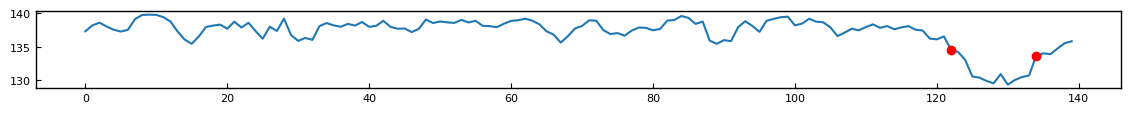

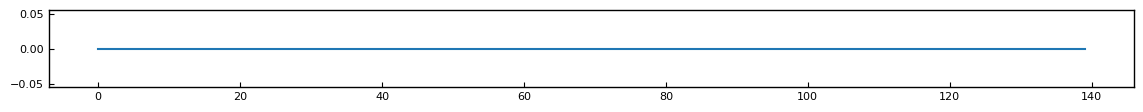

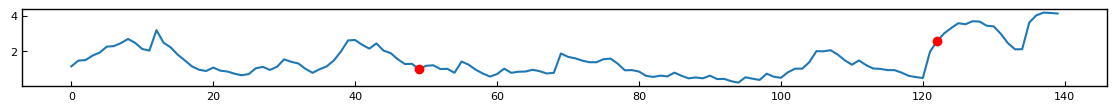

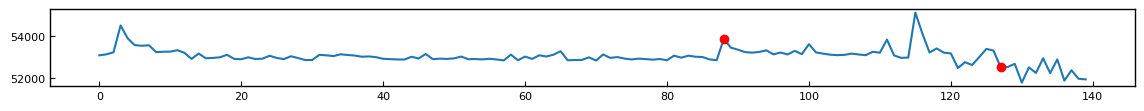

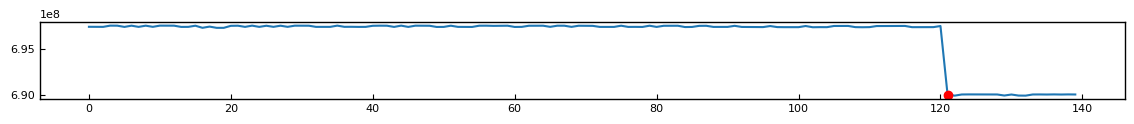

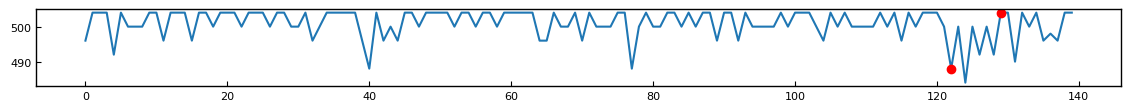

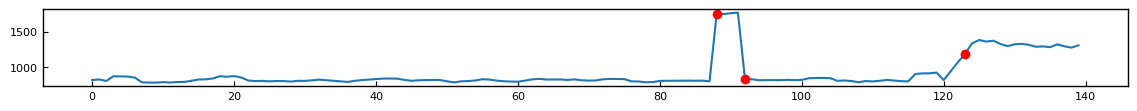

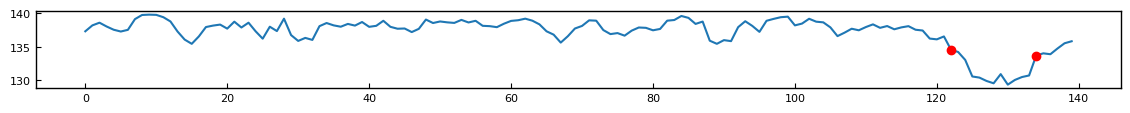

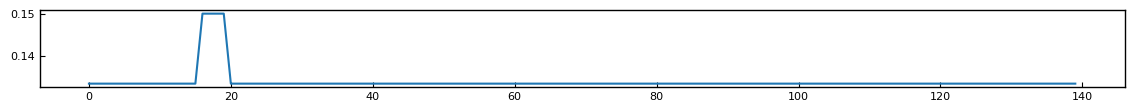

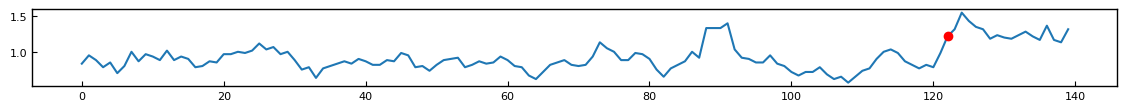

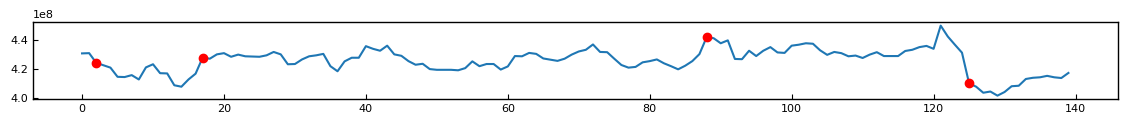

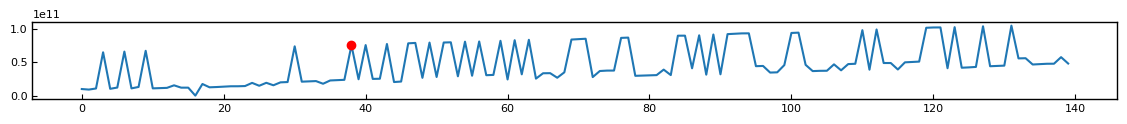

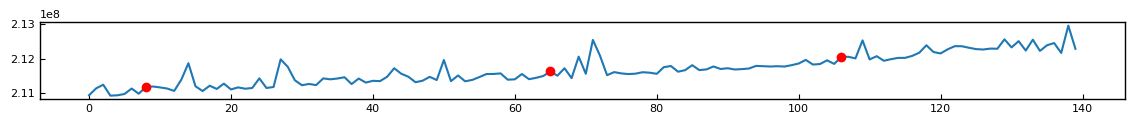

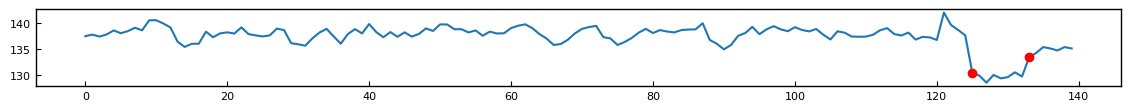

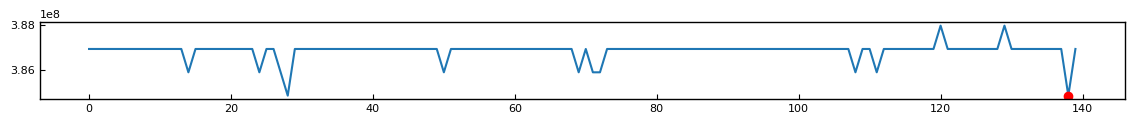

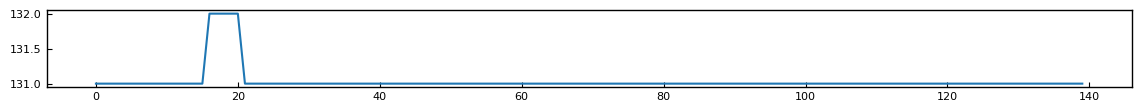

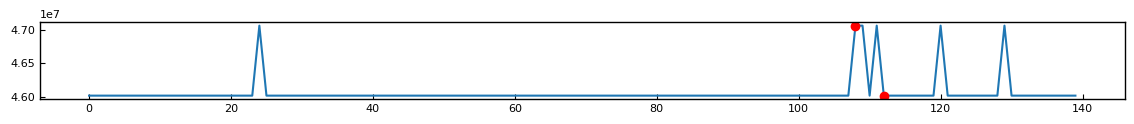

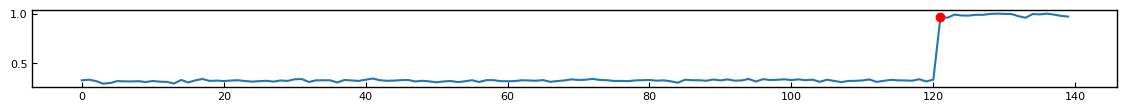

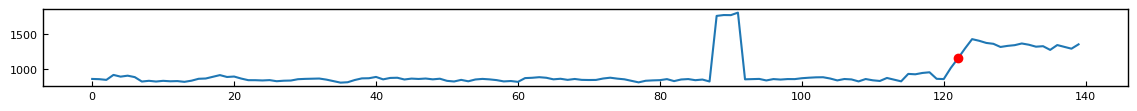

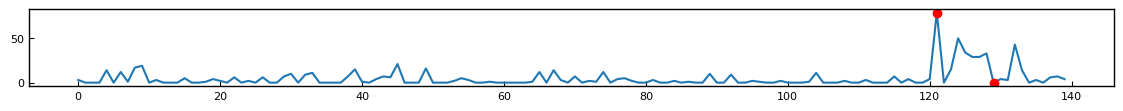

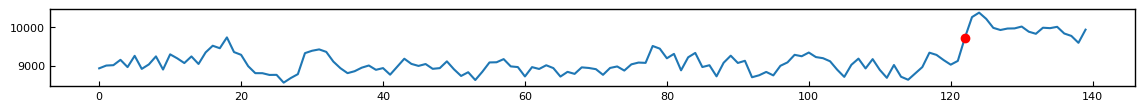

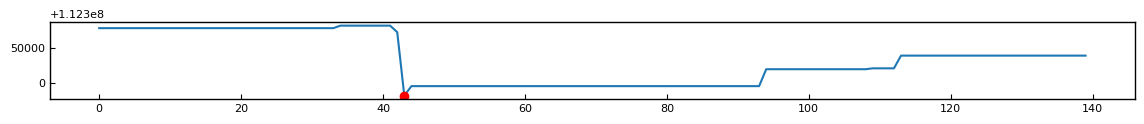

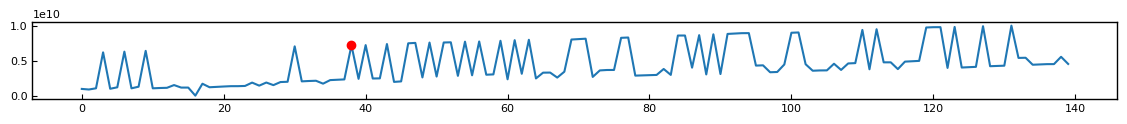

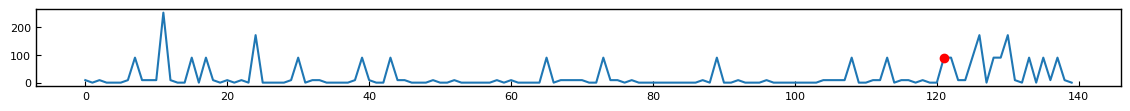

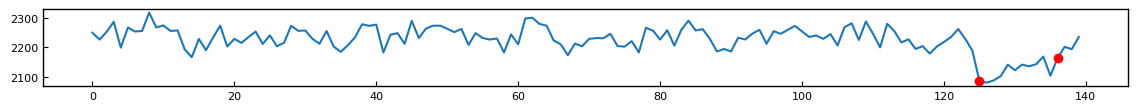

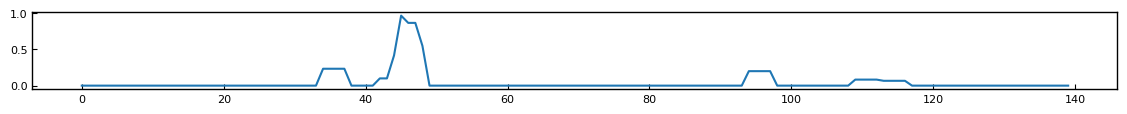

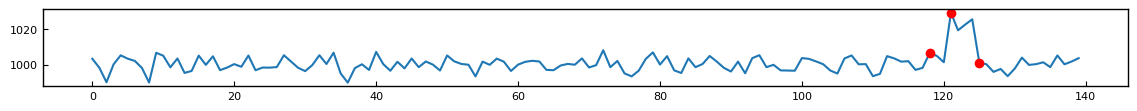

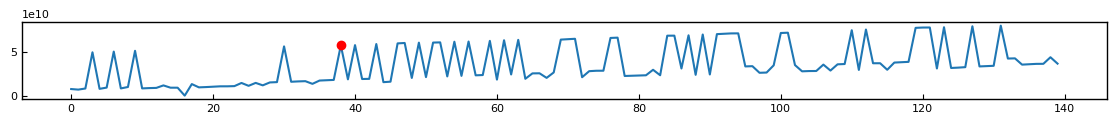

In [10]:
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams['axes.grid'] = False

trim_prefix = 40
for metric, cps in metric_and_changepoints:
    if len(cps) == 0:
        continue
    y = dataset[metric].values
    fig = plt.figure(figsize=(14, 1))
    plt.plot(range(len(y[trim_prefix:])), y[trim_prefix:])
    cps = [cp for cp in cps if cp - trim_prefix > 0]
    plt.plot(np.array(cps) - trim_prefix, y[cps], "o", color="red", markersize=6)

    plt.show()
    fig.savefig(f"../figures/{metric}_changepoint.svg", bbox_inches='tight')

plt.clf()
plt.close()

## Graphs for Observation 1

In [11]:
from eval.groundtruth import check_cause_metrics
from notebooklib.plot import plot_sli_and_causal_metrics

def plot_cause_metrics(dataset_by_chaos, chaos_type, chaos_comp, chaos_case_idx=0, trim_prefix=150, optional_cause=False, grid=True):
    record, data_df_by_metric_type = dataset_by_chaos[(chaos_type, chaos_comp)][chaos_case_idx]
    dataset = pd.concat([
        data_df_by_metric_type["containers"][0],
        data_df_by_metric_type["services"][0],
        data_df_by_metric_type["middlewares"][0],
    ], axis=1)
    cause_cols = [metric for metric in dataset.columns if record.pk.get_container_by_metric(metric) == record.chaos_comp()]
    cause_dataset = dataset.loc[:, cause_cols]
    # ok, cause_metrics = check_cause_metrics(record.pk, metrics=cause_dataset.columns.tolist(), chaos_type=record.chaos_type(), chaos_comp=record.chaos_comp(), optional_cause=True)
    plot_sli_and_causal_metrics(cause_dataset.iloc[trim_prefix:, :], record, optional_cause=optional_cause, ncols=2, graph_height=3.0, stacked=False, n_metrics_per_graph=3, grid=grid)


In [12]:
CHANGEPOINTS_GROUNDTRUTH = {
    ("carts", "pod-cpu-hog", 0): {
        "c-carts_cpu_user_seconds_total": 162,
        "c-carts_cpu_usage_seconds_total": 162,
        "c-carts_threads": 160,
        "m-carts_java_lang_OperatingSystem_ProcessCpuLoad": 160,
        "m-carts_java_lang_OperatingSystem_ProcessCpuTime": 164,
        "m-carts_java_lang_OperatingSystem_SystemCpuLoad": 160,
    },
    ("carts", "pod-memory-hog", 7): {
        "c-carts_memory_usage_bytes": 161,
        "c-carts_memory_cache": 161,
        "c-carts_memory_working_set_bytes": 161,
        "c-carts_threads": 161,
        "c-carts_memory_rss": 161,
        "c-carts_memory_mapped_file": 161,
        "m-carts_java_lang_OperatingSystem_FreePhysicalMemorySize": 161,
        "m-carts_java_lang_MemoryPool_Usage_used": 162,
    },
    ("ts-order-service", "pod-cpu-hog", 0): {
        "c-ts-order-service_cpu_user_seconds_total": 162,
        "c-ts-order-service_cpu_usage_seconds_total": 162,
        "c-ts-order-service_threads": 160,
        "m-ts-order-service_java_lang_OperatingSystem_ProcessCpuLoad": 161,
        "m-ts-order-service_java_lang_OperatingSystem_SystemCpuLoad": 161,
        "m-ts-order-service_java_lang_OperatingSystem_ProcessCpuTime": 161,
    },
    ("ts-order-service", "pod-memory-hog", 0): {
        "c-ts-order-service_threads": 162,
        "c-ts-order-service_memory_cache": 162, 
        "c-ts-order-service_memory_rss": 162,
        "c-ts-order-service_memory_usage_bytes": 162,
        "c-ts-order-service_memory_working_set_bytes": 162,
        "m-ts-order-service_java_lang_MemoryPool_Usage_used": 161,
        "m-ts-order-service_java_lang_OperatingSystem_FreePhysicalMemorySize": 160,
    },
}

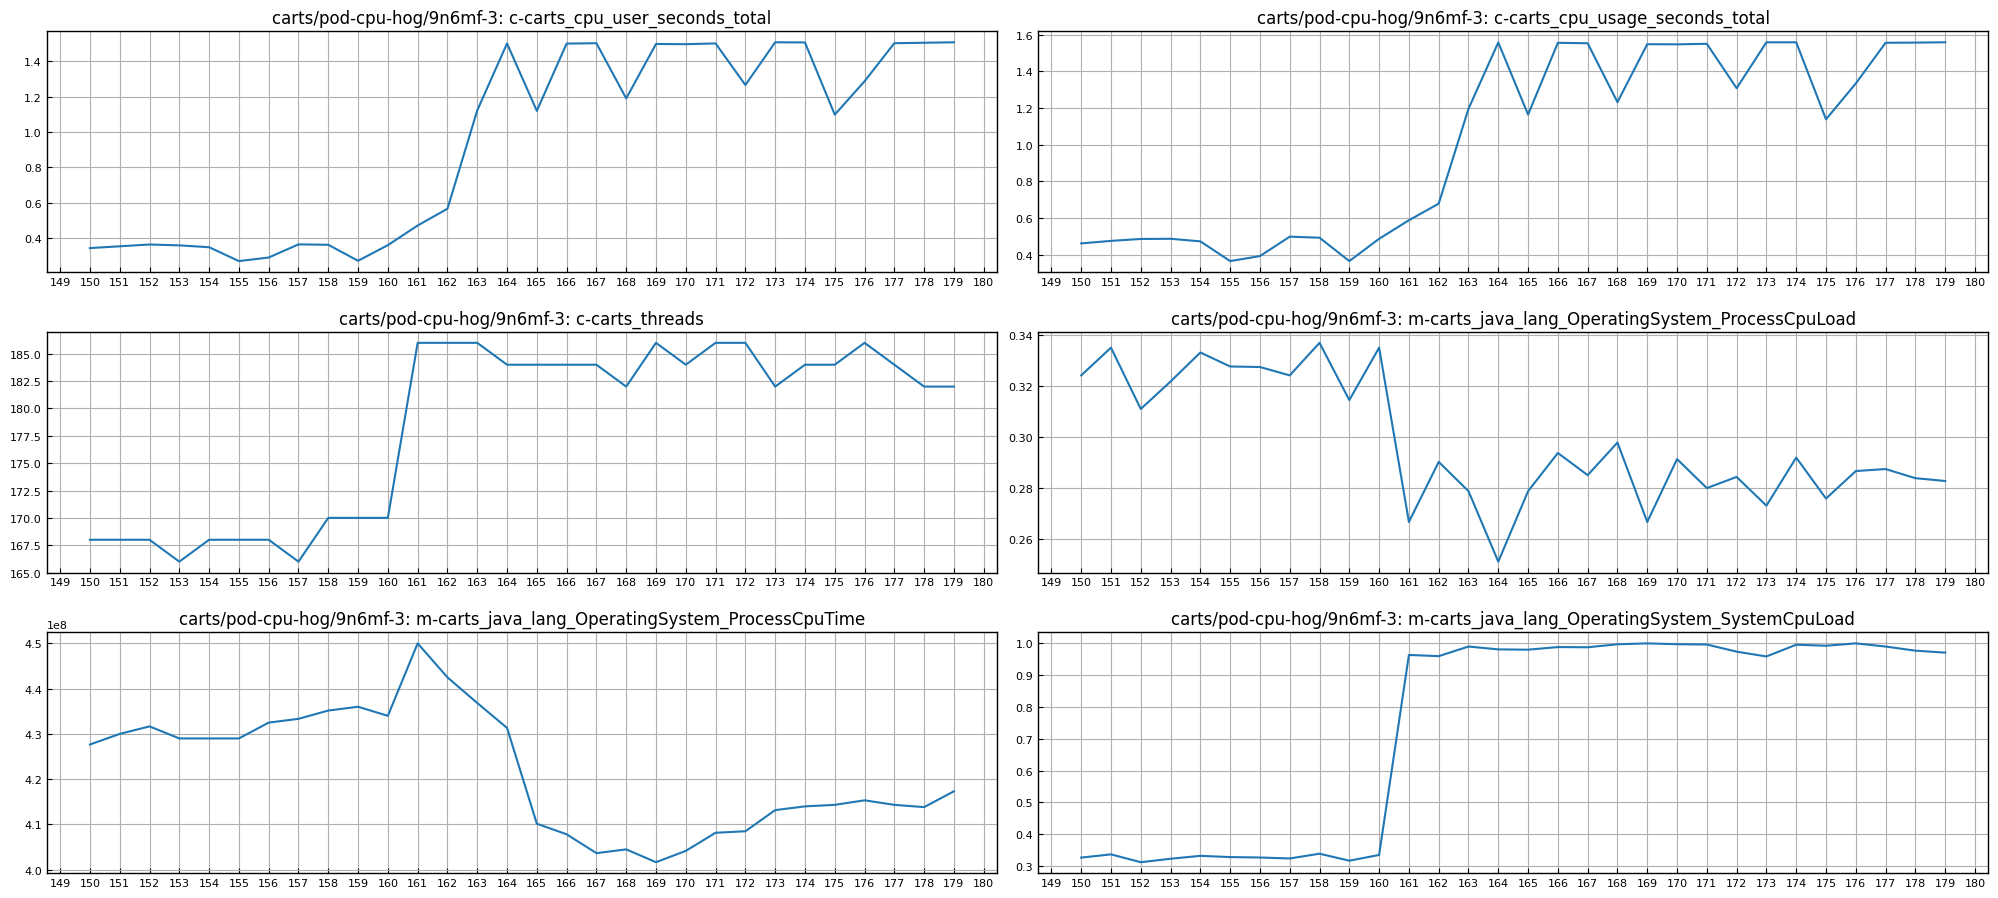

In [13]:
plot_cause_metrics(dataset_by_chaos, "pod-cpu-hog", "carts", optional_cause=False)

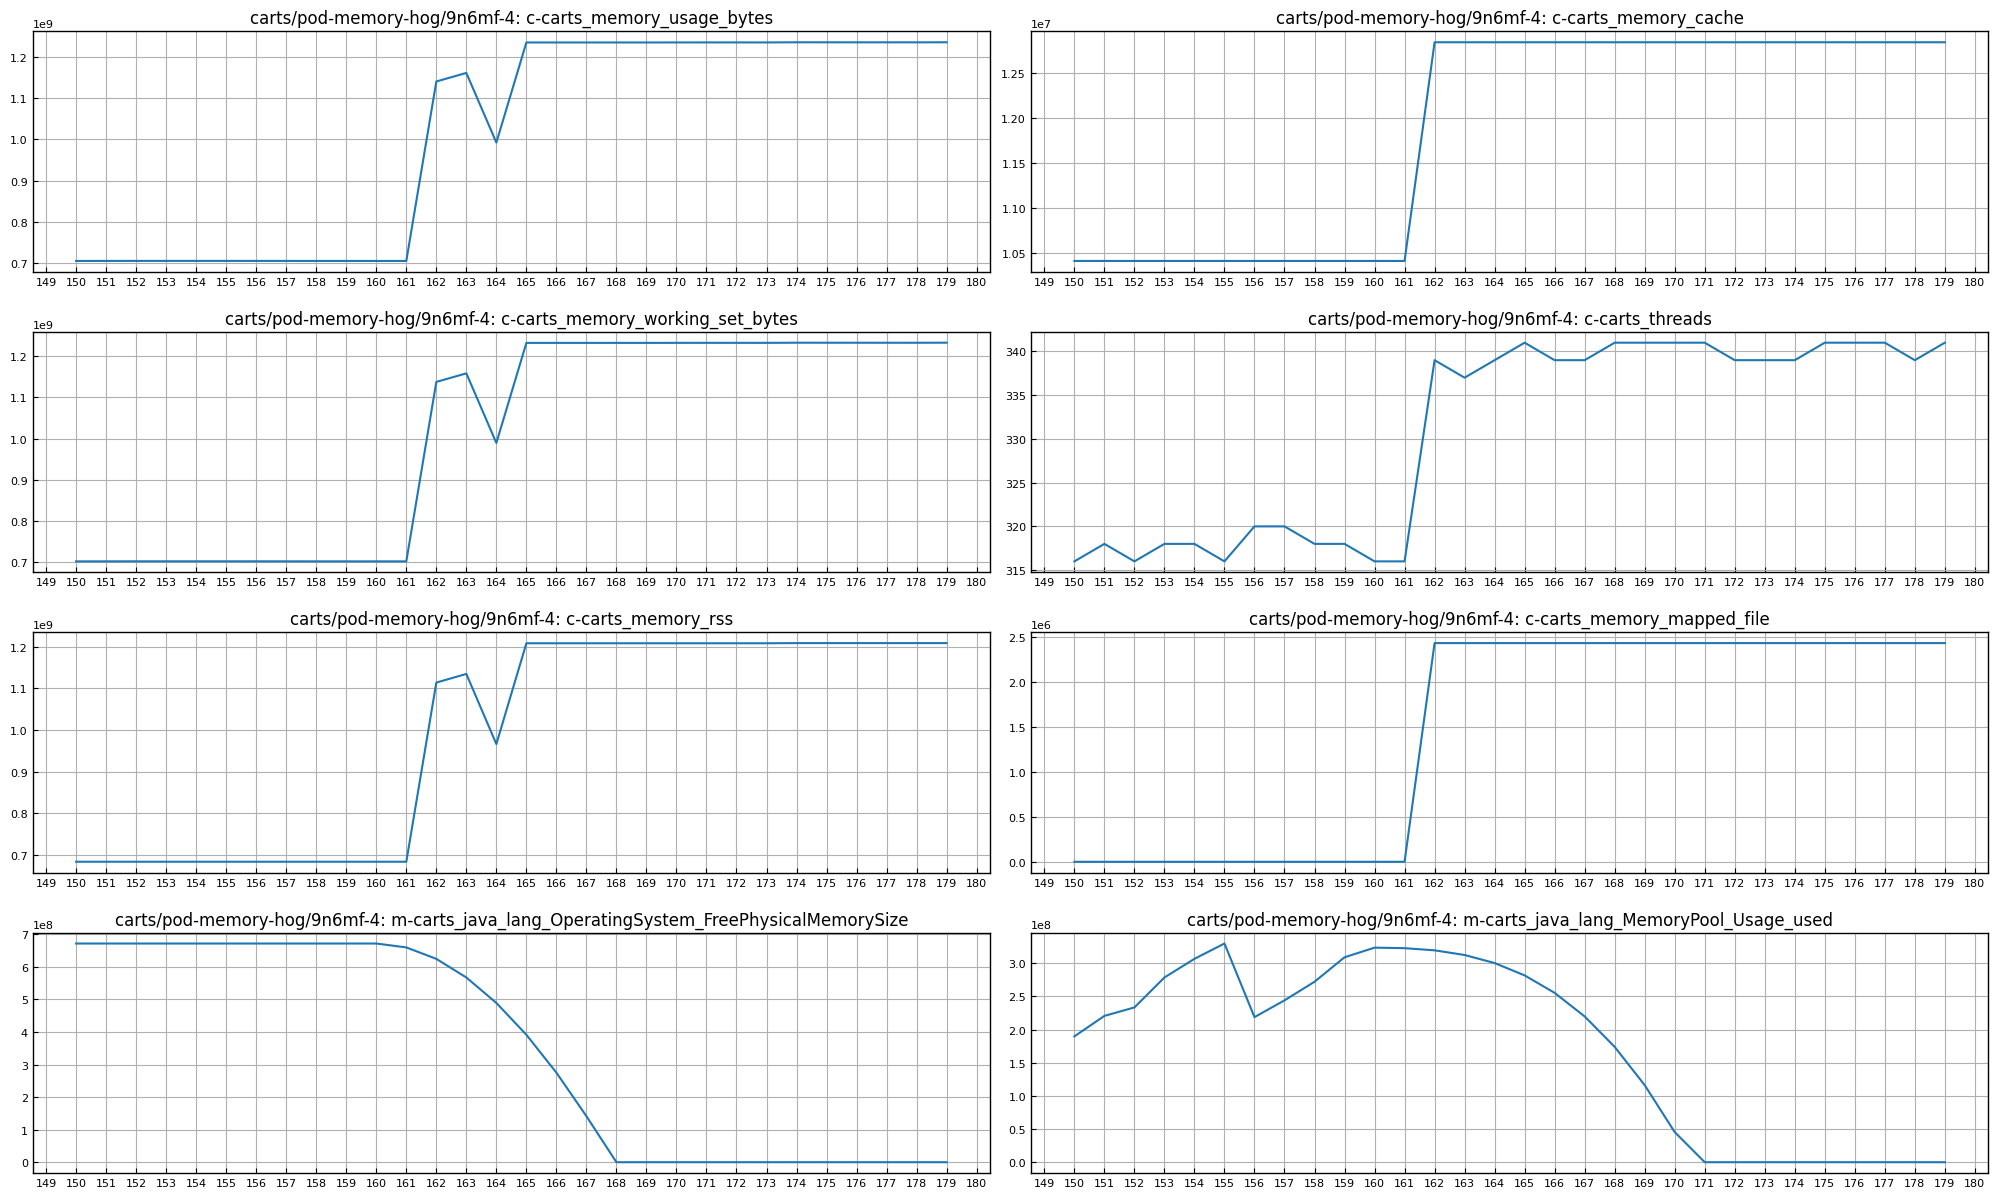

In [14]:
plot_cause_metrics(dataset_by_chaos, "pod-memory-hog", "carts", 7, optional_cause=False, grid=True)

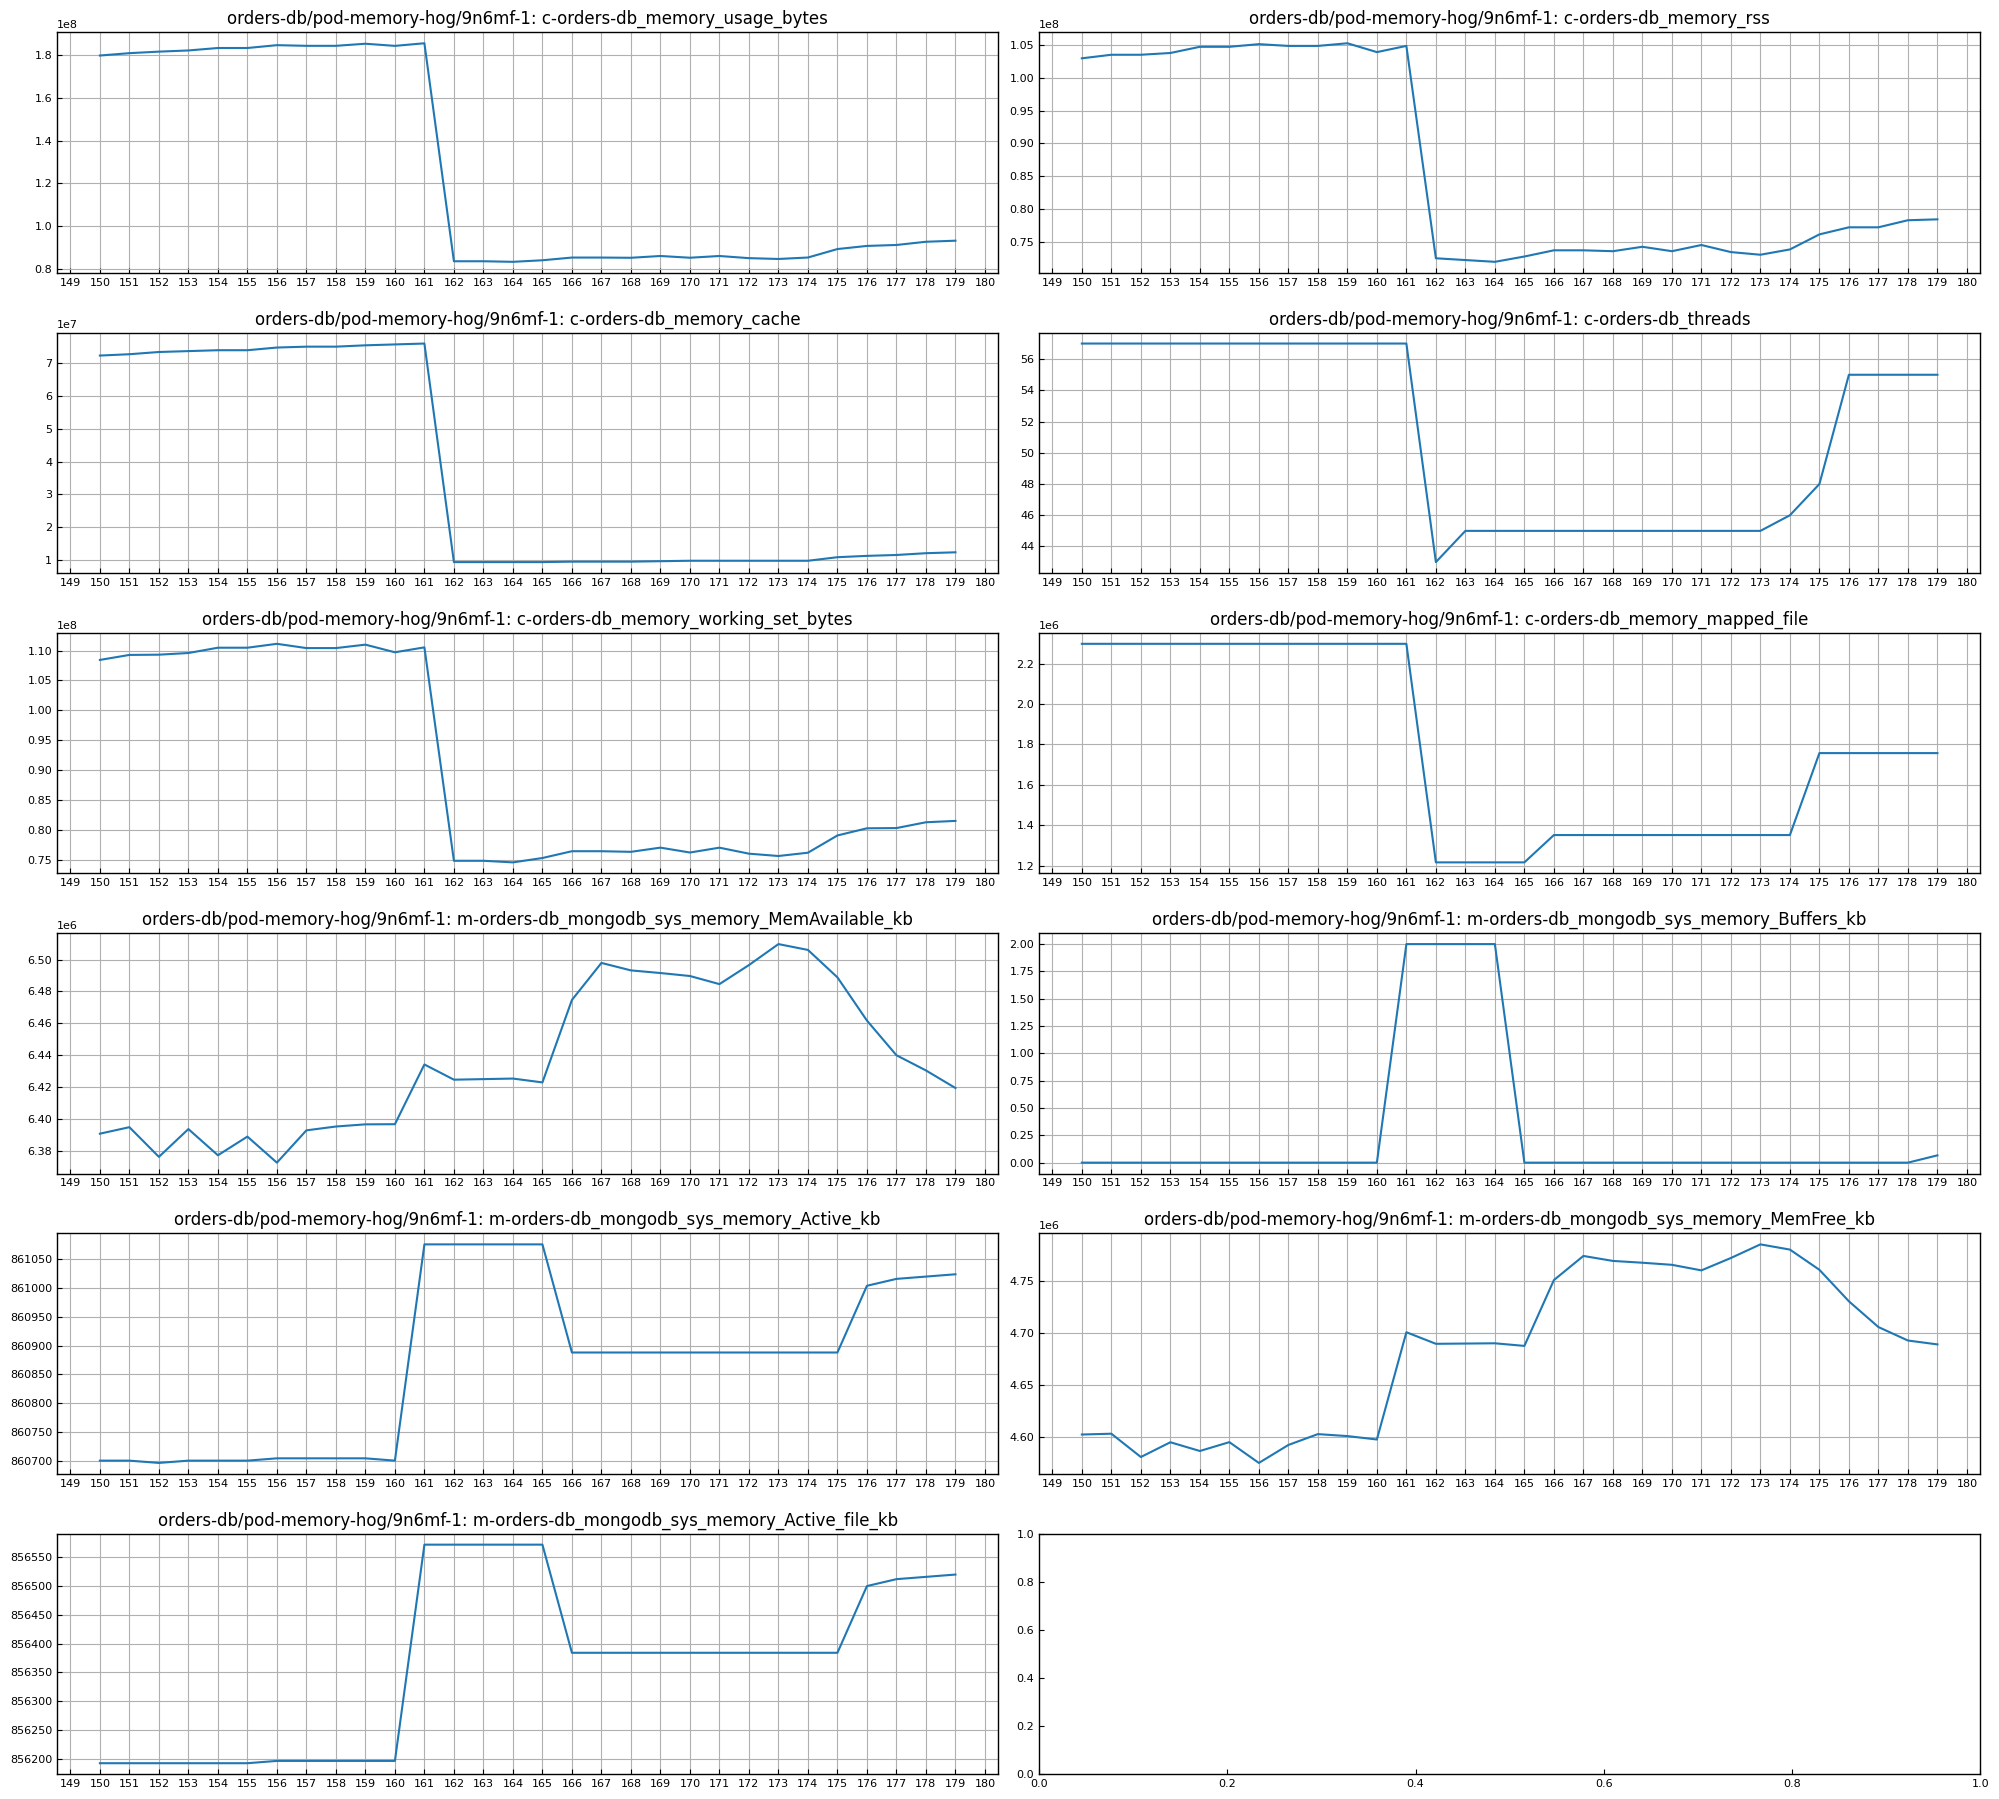

In [15]:
plot_cause_metrics(dataset_by_chaos, "pod-memory-hog", "orders-db", 0, optional_cause=False, grid=True)

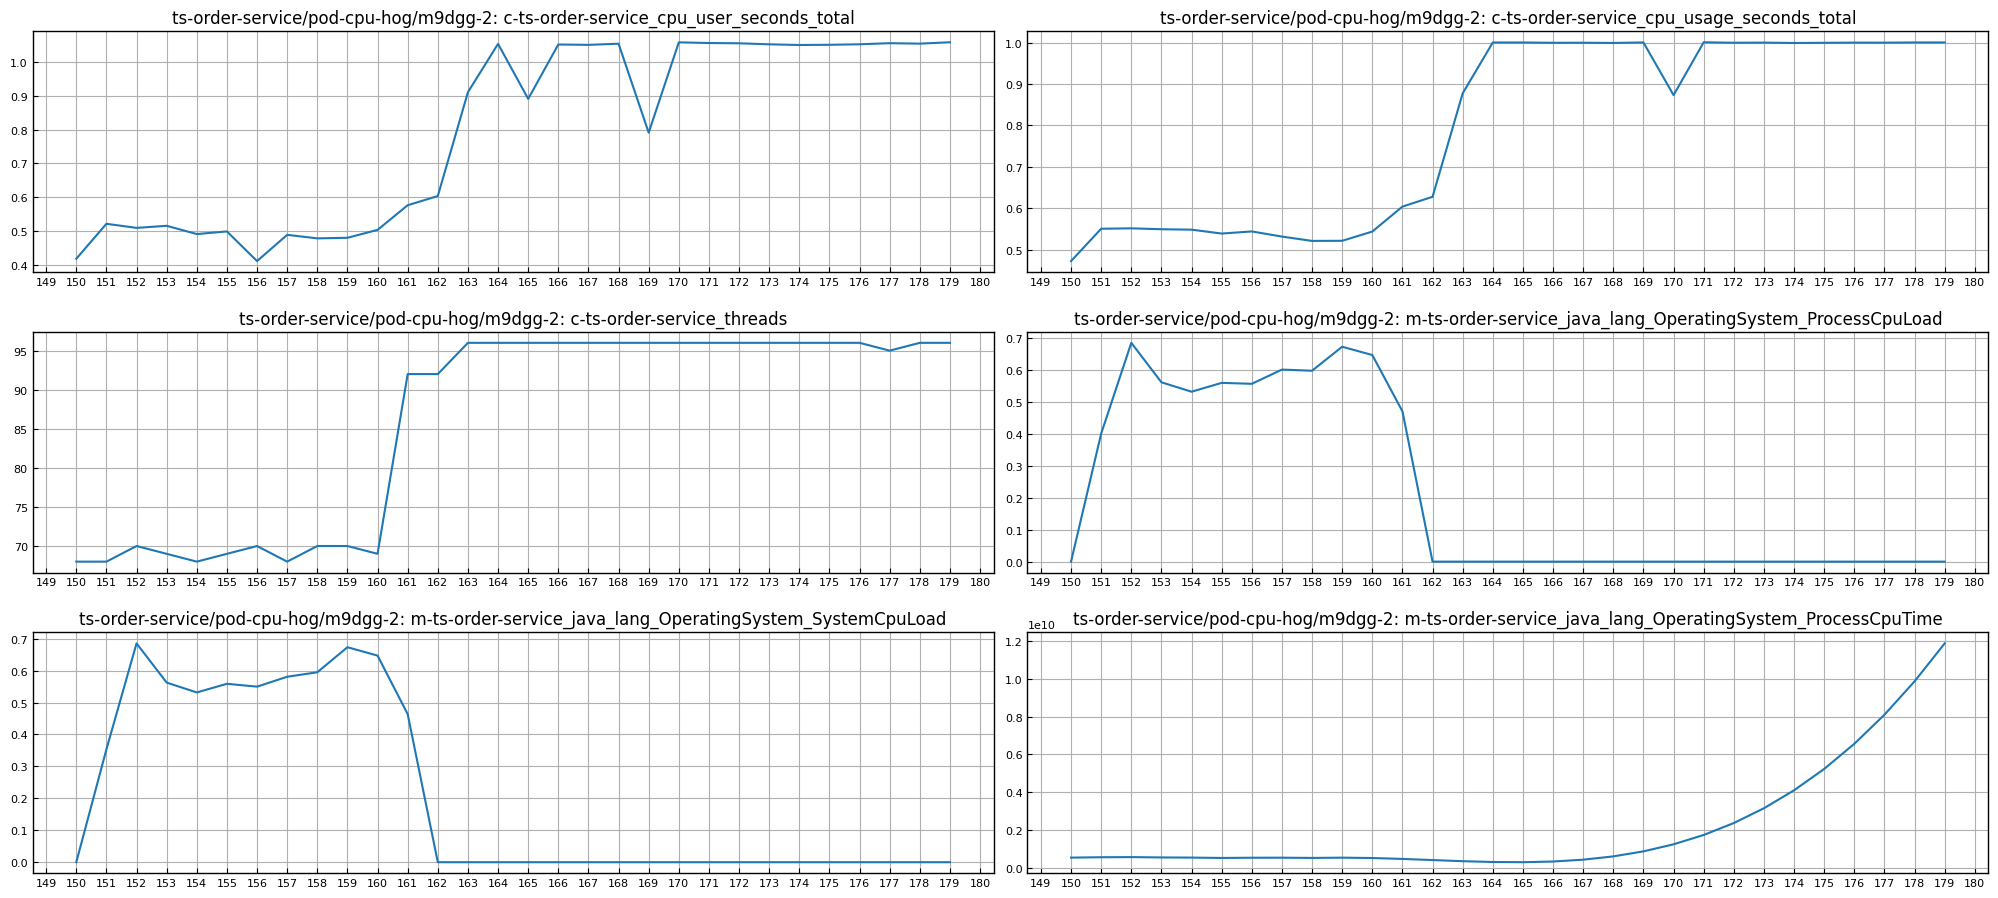

In [16]:
plot_cause_metrics(tt_dataset_by_chaos, "pod-cpu-hog", "ts-order-service", 0, optional_cause=False, grid=True)

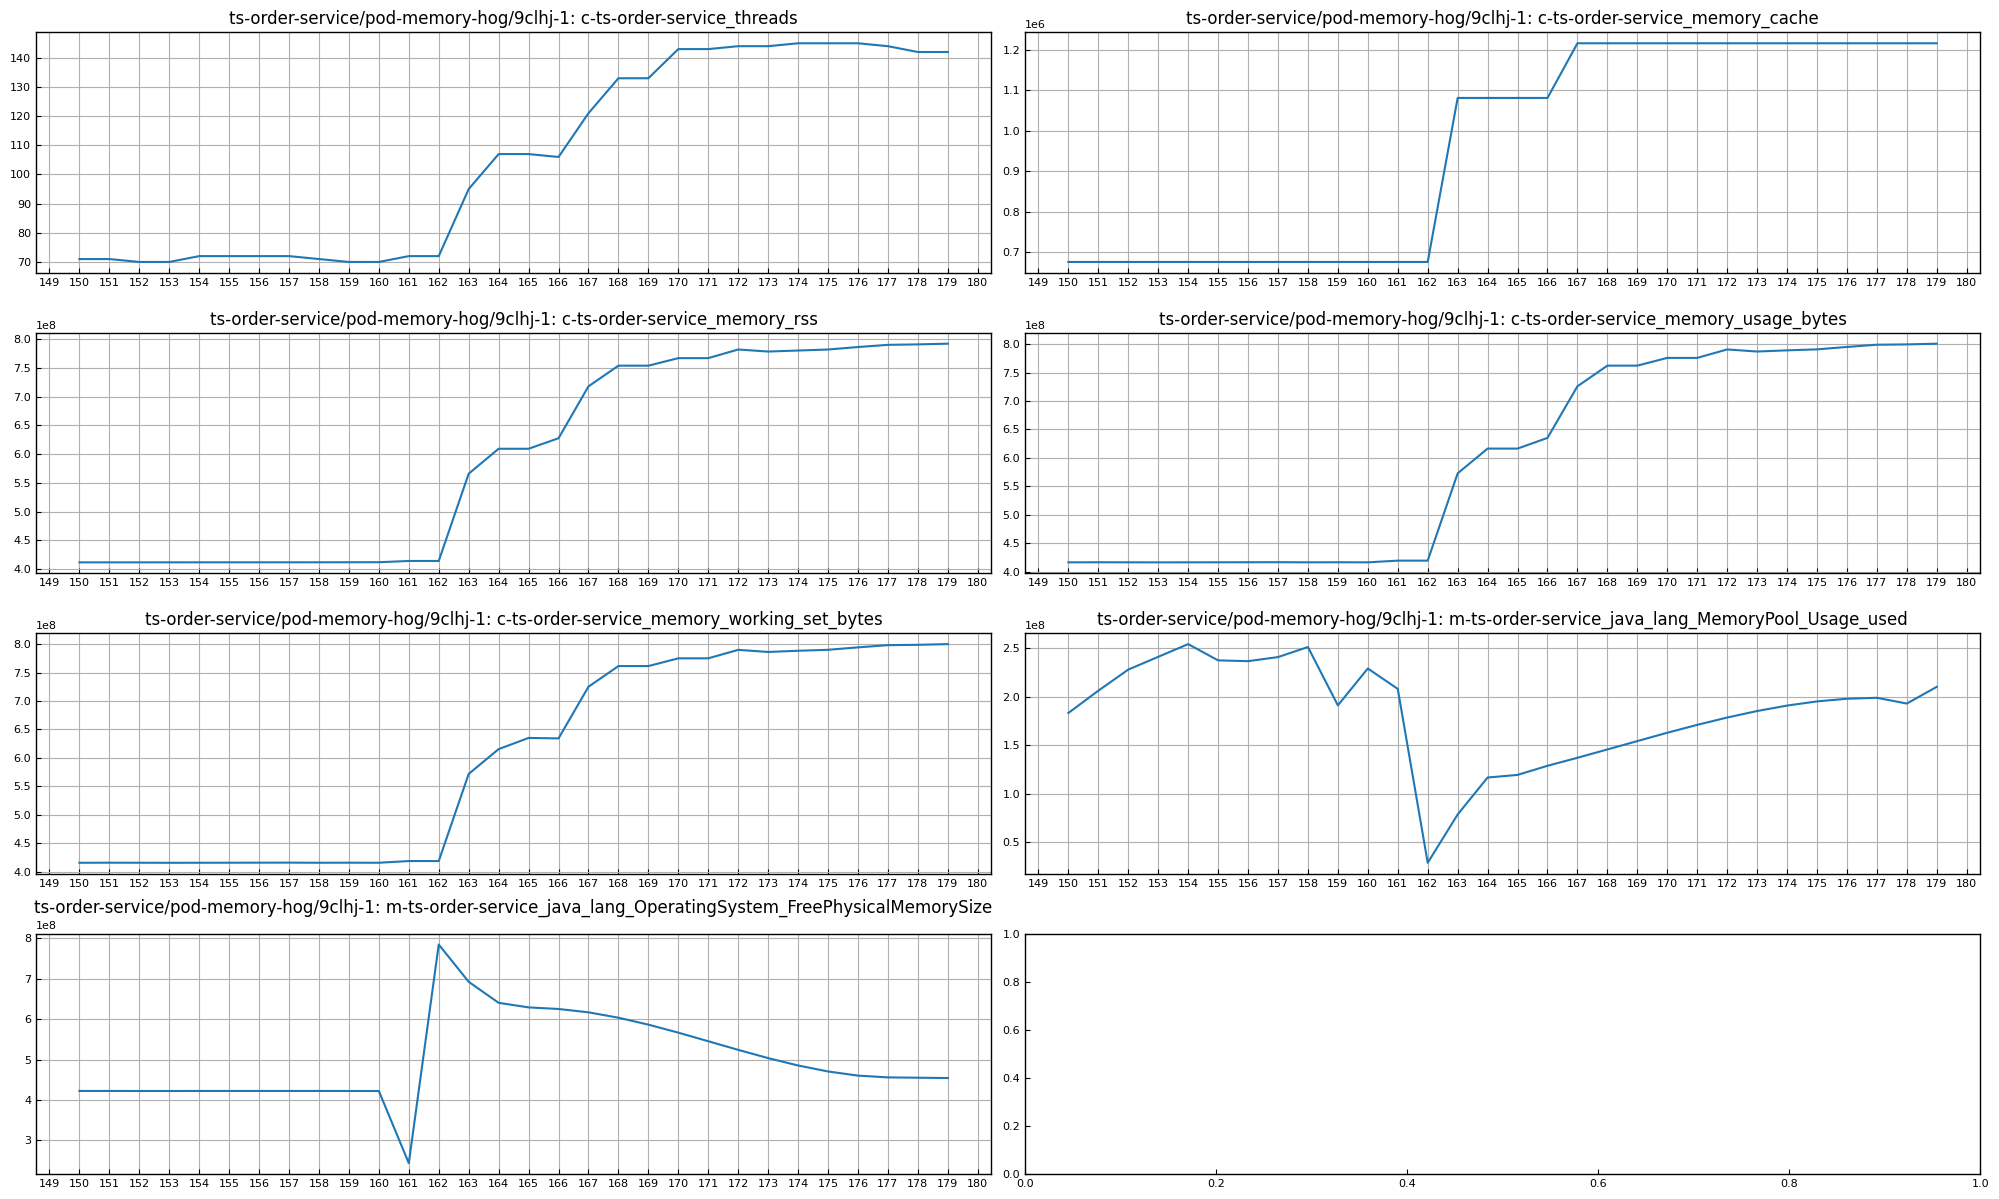

In [17]:
plot_cause_metrics(tt_dataset_by_chaos, "pod-memory-hog", "ts-order-service", 0, optional_cause=False, grid=True)

### Corr clustermap

In [18]:
def plot_heatmap(dataset_by_chaos, chaos_type, chaos_comp, chaos_case_idx=0, trim_prefix=150, optional_cause=False, annot_size=11):
    record, data_df_by_metric_type = dataset_by_chaos[(chaos_type, chaos_comp)][chaos_case_idx]
    dataset = pd.concat([
        data_df_by_metric_type["containers"][0],
        data_df_by_metric_type["services"][0],
        data_df_by_metric_type["middlewares"][0],
    ], axis=1)
    ok, cause_metrics = check_cause_metrics(
        record.pk,
        record.data_df.columns.tolist(),
        record.chaos_type(),
        record.chaos_comp(),
        optional_cause=optional_cause,
    )
    cause_dataset = dataset.loc[:, cause_metrics.tolist()]
    corr = cause_dataset.iloc[trim_prefix:, :].corr().abs()
    corr.fillna(0)
    short_columns = {m: m.split("-", maxsplit=1)[1].split("_", maxsplit=1)[1] for m in corr.columns}
    corr.rename(columns=short_columns, index=short_columns, inplace=True)
    # w = corr.shape[0] * 0.5

    fig = plt.figure(tight_layout=True, figsize=(6, 6))
    ax = fig.subplots(nrows=1, ncols=1)
    ax = sns.heatmap(corr, cmap='RdBu', annot=True, annot_kws={"size": annot_size}, vmin=0, vmax=1, ax=ax)
    # ax.set_xticks(np.arange(corr.shape[0]))
    # ax.set_yticks(np.arange(corr.shape[0]))
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=7, rotation=45, ha="right")
    ax.set_yticklabels(ax.get_xticklabels(), fontsize=7, rotation=45, va='top')
    plt.show()
    # sns.clustermap(corr, method="complete", cmap='RdBu', annot=True, 
    #             annot_kws={"size": 7}, vmin=0, vmax=1, figsize=(w,w))


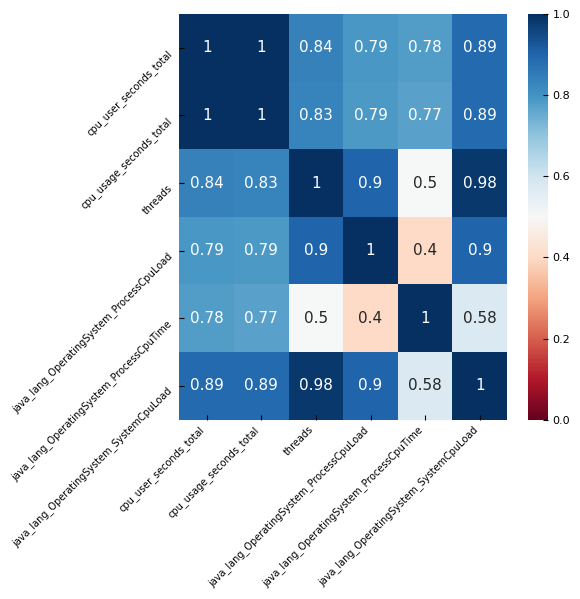

In [19]:
plot_heatmap(dataset_by_chaos, "pod-cpu-hog", "carts", 0)

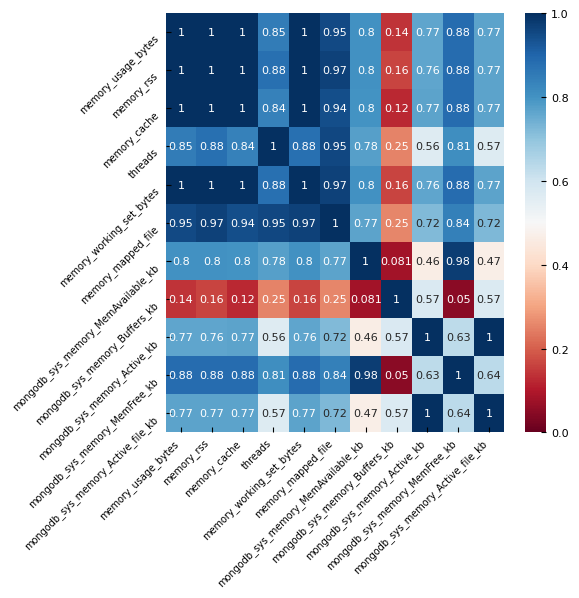

In [20]:
plot_heatmap(dataset_by_chaos, "pod-memory-hog", "orders-db", 0, annot_size=8)

### Correlation Barplot

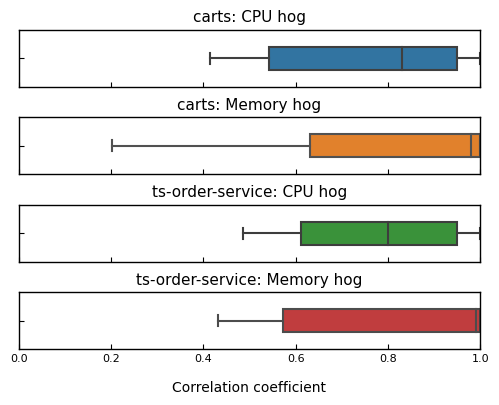

In [21]:
import itertools

# def plot_bar_cause_metrics(dataset_by_chaos, chaos_type, chaos_comp, chaos_case_idx=0, trim_prefix=150, optional_cause=False):
trim_prefix=0
chaos_to_corr = {}
for dset_by_chaos, chaos_type, chaos_comp, chaos_case_idx in [
    (dataset_by_chaos, "pod-cpu-hog", "carts", 0),
    (dataset_by_chaos, "pod-memory-hog", "carts", 0),
    (tt_dataset_by_chaos, "pod-cpu-hog", "ts-order-service", 0),
    (tt_dataset_by_chaos, "pod-memory-hog", "ts-order-service", 0),
]:
    record, data_df_by_metric_type = dset_by_chaos[(chaos_type, chaos_comp)][chaos_case_idx]
    dataset = pd.concat([
        data_df_by_metric_type["containers"][0],
        data_df_by_metric_type["services"][0],
        data_df_by_metric_type["middlewares"][0],
    ], axis=1)
    ok, cause_metrics = check_cause_metrics(
        record.pk,
        dataset.columns.tolist(),
        record.chaos_type(),
        record.chaos_comp(),
        optional_cause=False,
    )
    cause_dataset = dataset.loc[:, cause_metrics.tolist()]
    corr = cause_dataset.iloc[trim_prefix:, :].corr().abs()
    flatten_corr = corr.values.flatten()
    match chaos_type:
        case "pod-cpu-hog":
            chaos_to_corr[f"{chaos_comp}: CPU hog"] = flatten_corr
        case "pod-memory-hog":
            chaos_to_corr[f"{chaos_comp}: Memory hog"] = flatten_corr

fig = plt.figure(tight_layout=True, figsize=(5, 4))
fig.supxlabel("Correlation coefficient", fontsize=10)
axes = fig.subplots(ncols=1, nrows=len(chaos_to_corr), sharex=True)
palette = itertools.cycle(sns.color_palette())
for ax, (k, v) in zip(axes, chaos_to_corr.items()):
    ax = sns.boxplot(v, orient="h", color=next(palette), width=0.4, showmeans=False, showfliers=True, labels=[k], ax=ax)
    ax.set_title(k, fontsize=11)
    ax.set_xlim(0, 1)
    ax.set_yticklabels([])
plt.show()

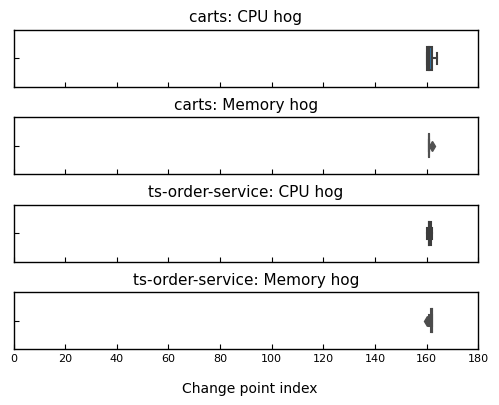

In [22]:
chaos_to_cps = {}
for (chaos_comp, chaos_type, chaos_case_idx), metric_to_changepoint in CHANGEPOINTS_GROUNDTRUTH.items():
    cps = list(metric_to_changepoint.values())
    match chaos_type:
        case "pod-cpu-hog":
            chaos_to_cps[f"{chaos_comp}: CPU hog"] = cps
        case "pod-memory-hog":
            chaos_to_cps[f"{chaos_comp}: Memory hog"] = cps

fig = plt.figure(tight_layout=True, figsize=(5, 4))
fig.supxlabel("Change point index", fontsize=10)
axes = fig.subplots(nrows=len(chaos_to_cps), ncols=1, sharex=True)
palette = itertools.cycle(sns.color_palette())
for ax, (k, v) in zip(axes, chaos_to_cps.items()):
    ax = sns.boxplot(v, orient="h", color=next(palette), width=0.4, showmeans=False, showfliers=True, labels=[k], ax=ax)
    ax.set_title(k, fontsize=11)
    ax.set_xlim(0, 180)
    ax.set_yticklabels([])
plt.show()

## Graphs for Observation 2

In [23]:
from notebooklib.plot import plot_dataset_dataframe

def plot_cause_service_metrics(dataset_by_chaos, chaos_type, chaos_comp, chaos_case_idx=0, trim_prefix=150,grid=True):
    record, data_df_by_metric_type = dataset_by_chaos[(chaos_type, chaos_comp)][chaos_case_idx]
    dataset = pd.concat([
        data_df_by_metric_type["containers"][0],
        data_df_by_metric_type["services"][0],
        data_df_by_metric_type["middlewares"][0],
    ], axis=1)
    cause_cols = [metric for metric in dataset.columns if record.pk.get_container_by_metric(metric) == record.chaos_comp()]
    cause_dataset = dataset.loc[:, cause_cols]
    # ok, cause_metrics = check_cause_metrics(record.pk, metrics=cause_dataset.columns.tolist(), chaos_type=record.chaos_type(), chaos_comp=record.chaos_comp(), optional_cause=True)

    plot_dataset_dataframe(cause_dataset.iloc[trim_prefix:, :], record, ncols=2, graph_height=3.0, grid=grid, logging=True)



In [24]:
# plot_cause_service_metrics(dataset_by_chaos, "pod-cpu-hog", "carts", 0)

## Boxplot pairwise of cause service

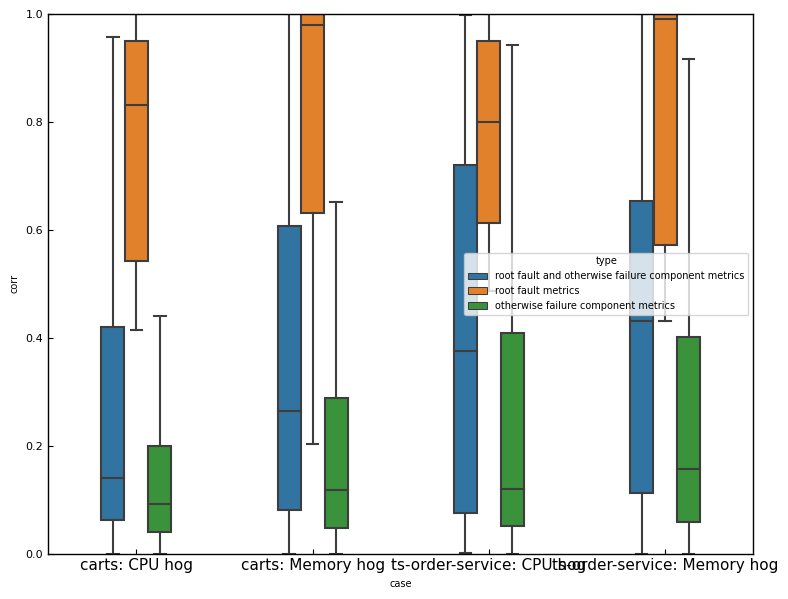

In [25]:
import itertools
from scipy.stats import pearsonr


fig = plt.figure(tight_layout=True, figsize=(8, 6))
# fig.supxlabel("Correlation coefficient", fontsize=10)
# fig.legend(["failure component metrics", "root fault metrics"], loc='lower center', fontsize=10)
ax = fig.subplots(ncols=1, nrows=1)
trim_prefix = 0
items = []
for (dset_by_chaos, chaos_type, chaos_comp, chaos_case_idx)in [
    (dataset_by_chaos, "pod-cpu-hog", "carts", 0),
    (dataset_by_chaos, "pod-memory-hog", "carts", 0),
    (tt_dataset_by_chaos, "pod-cpu-hog", "ts-order-service", 0),
    (tt_dataset_by_chaos, "pod-memory-hog", "ts-order-service", 0),
]:
    record, data_df_by_metric_type = dset_by_chaos[(chaos_type, chaos_comp)][chaos_case_idx]
    dataset = pd.concat([
        data_df_by_metric_type["containers"][0],
        data_df_by_metric_type["services"][0],
        data_df_by_metric_type["middlewares"][0],
    ], axis=1)
    ok, root_fault_metrics = check_cause_metrics(
        record.pk,
        dataset.columns.tolist(),
        record.chaos_type(),
        record.chaos_comp(),
        optional_cause=False,
    )
    root_fault_dataset = dataset.loc[:, root_fault_metrics.tolist()]
    failure_component_dataset = dataset.loc[
        :,
        [
            metric for metric in dataset.columns
            if record.pk.get_container_by_metric(metric) == record.chaos_comp()
            or record.pk.get_service_by_metric((metric)) == record.pk.get_service_by_container(record.chaos_comp())
            if metric not in root_fault_metrics.tolist()
        ],
    ]

    fault_corrs = root_fault_dataset.iloc[trim_prefix:, :].corr().abs().values.flatten()
    # pairwise correlation of combination of failure component metrics and root fault metrics
    root_fault_and_otherwise_corrs = []
    for col_a, col_b in itertools.product(root_fault_dataset.columns, failure_component_dataset.columns):
        coeff, _ = pearsonr(root_fault_dataset.loc[:, col_a], failure_component_dataset.loc[:, col_b])
        root_fault_and_otherwise_corrs.append(np.abs(coeff))

    comp_corrs = failure_component_dataset.iloc[trim_prefix:, :].corr().abs().values.flatten()

    match chaos_type:
        case "pod-cpu-hog":
            title = f"{chaos_comp}: CPU hog"
        case "pod-memory-hog":
            title = f"{chaos_comp}: Memory hog"
        case _:
            assert False

    items.extend(
        [{"corr": corr, "type": "root fault and otherwise failure component metrics", "case": title} for corr in root_fault_and_otherwise_corrs] + 
        [{"corr": corr, "type": "root fault metrics", "case": title} for corr in fault_corrs] +
        [{"corr": corr, "type": "otherwise failure component metrics", "case": title} for corr in comp_corrs]
    )
    
box = sns.boxplot(
    data=pd.DataFrame(items), 
    x="case", y="corr", hue="type",
    orient="v", showmeans=False, width=0.4, showfliers=False, ax=ax)
# box.set_title(title, fontsize=11)
box.set_ylim(0, 1)
box.set_xticklabels(box.get_xticklabels(), fontsize=11)
# box.set_yticklabels([])
# box.set_xticklabels([])

plt.show()

In [51]:
def plot_clustermap(dataset_by_chaos, chaos_type, chaos_comp, chaos_case_idx=0, trim_prefix=0, optional_cause=False, annot_size=11):
    sns.set_theme()

    record, data_df_by_metric_type = dataset_by_chaos[(chaos_type, chaos_comp)][chaos_case_idx]
    dataset = pd.concat([
        data_df_by_metric_type["containers"][0],
        data_df_by_metric_type["services"][0],
        data_df_by_metric_type["middlewares"][0],
    ], axis=1)
    ok, root_fault_metrics = check_cause_metrics(
        record.pk,
        dataset.columns.tolist(),
        record.chaos_type(),
        record.chaos_comp(),
        optional_cause=optional_cause,
    )
    root_fault_dataset = dataset.loc[:, root_fault_metrics.tolist()]
    failure_component_dataset = dataset.loc[
        :,
        [
            metric for metric in dataset.columns
            if record.pk.get_container_by_metric(metric) == record.chaos_comp()
            # or record.pk.get_service_by_metric((metric)) == record.pk.get_service_by_container(record.chaos_comp())
        ],
    ]
    
    # corr = root_fault_dataset.iloc[trim_prefix:, :].corr().abs()
    corr = failure_component_dataset.iloc[trim_prefix:, :].corr().abs()
    # corr.fillna(0)
    short_columns = {m: f"{'r' if m in root_fault_metrics else 'm'}-{str(i+1).rjust(2, '0')}" for i, m in enumerate(corr.columns)}
    corr.rename(columns=short_columns, index=short_columns, inplace=True)

    np.fill_diagonal(corr.values, 0)
    low_corr_metrics = corr.columns[(corr <= 0.2).all()].tolist()
    print(low_corr_metrics)
    corr = corr.drop(low_corr_metrics, axis=0)
    corr = corr.drop(low_corr_metrics, axis=1)
    np.fill_diagonal(corr.values, 1)

    # w = corr.shape[0] * 0.5
    w = 30
    g = sns.clustermap(
        corr.round(2), method="ward", annot=False, annot_kws={"size": 6}, vmin=0, vmax=1,
        figsize=(w, w), xticklabels=False, yticklabels=False,# linewidths=.1,
        dendrogram_ratio=(.1, .2), cbar_pos=(.02, .32, .03, .2),
    )
    g.ax_row_dendrogram.remove()

    # ax.set_xticks(np.arange(corr.shape[0]))
    # ax.set_yticks(np.arange(corr.shape[0]))
    # ax.set_xticklabels(ax.get_xticklabels(), fontsize=7, rotation=45, ha="right")
    # ax.set_yticklabels(ax.get_xticklabels(), fontsize=7, rotation=45, va='top')
    plt.show()


[]


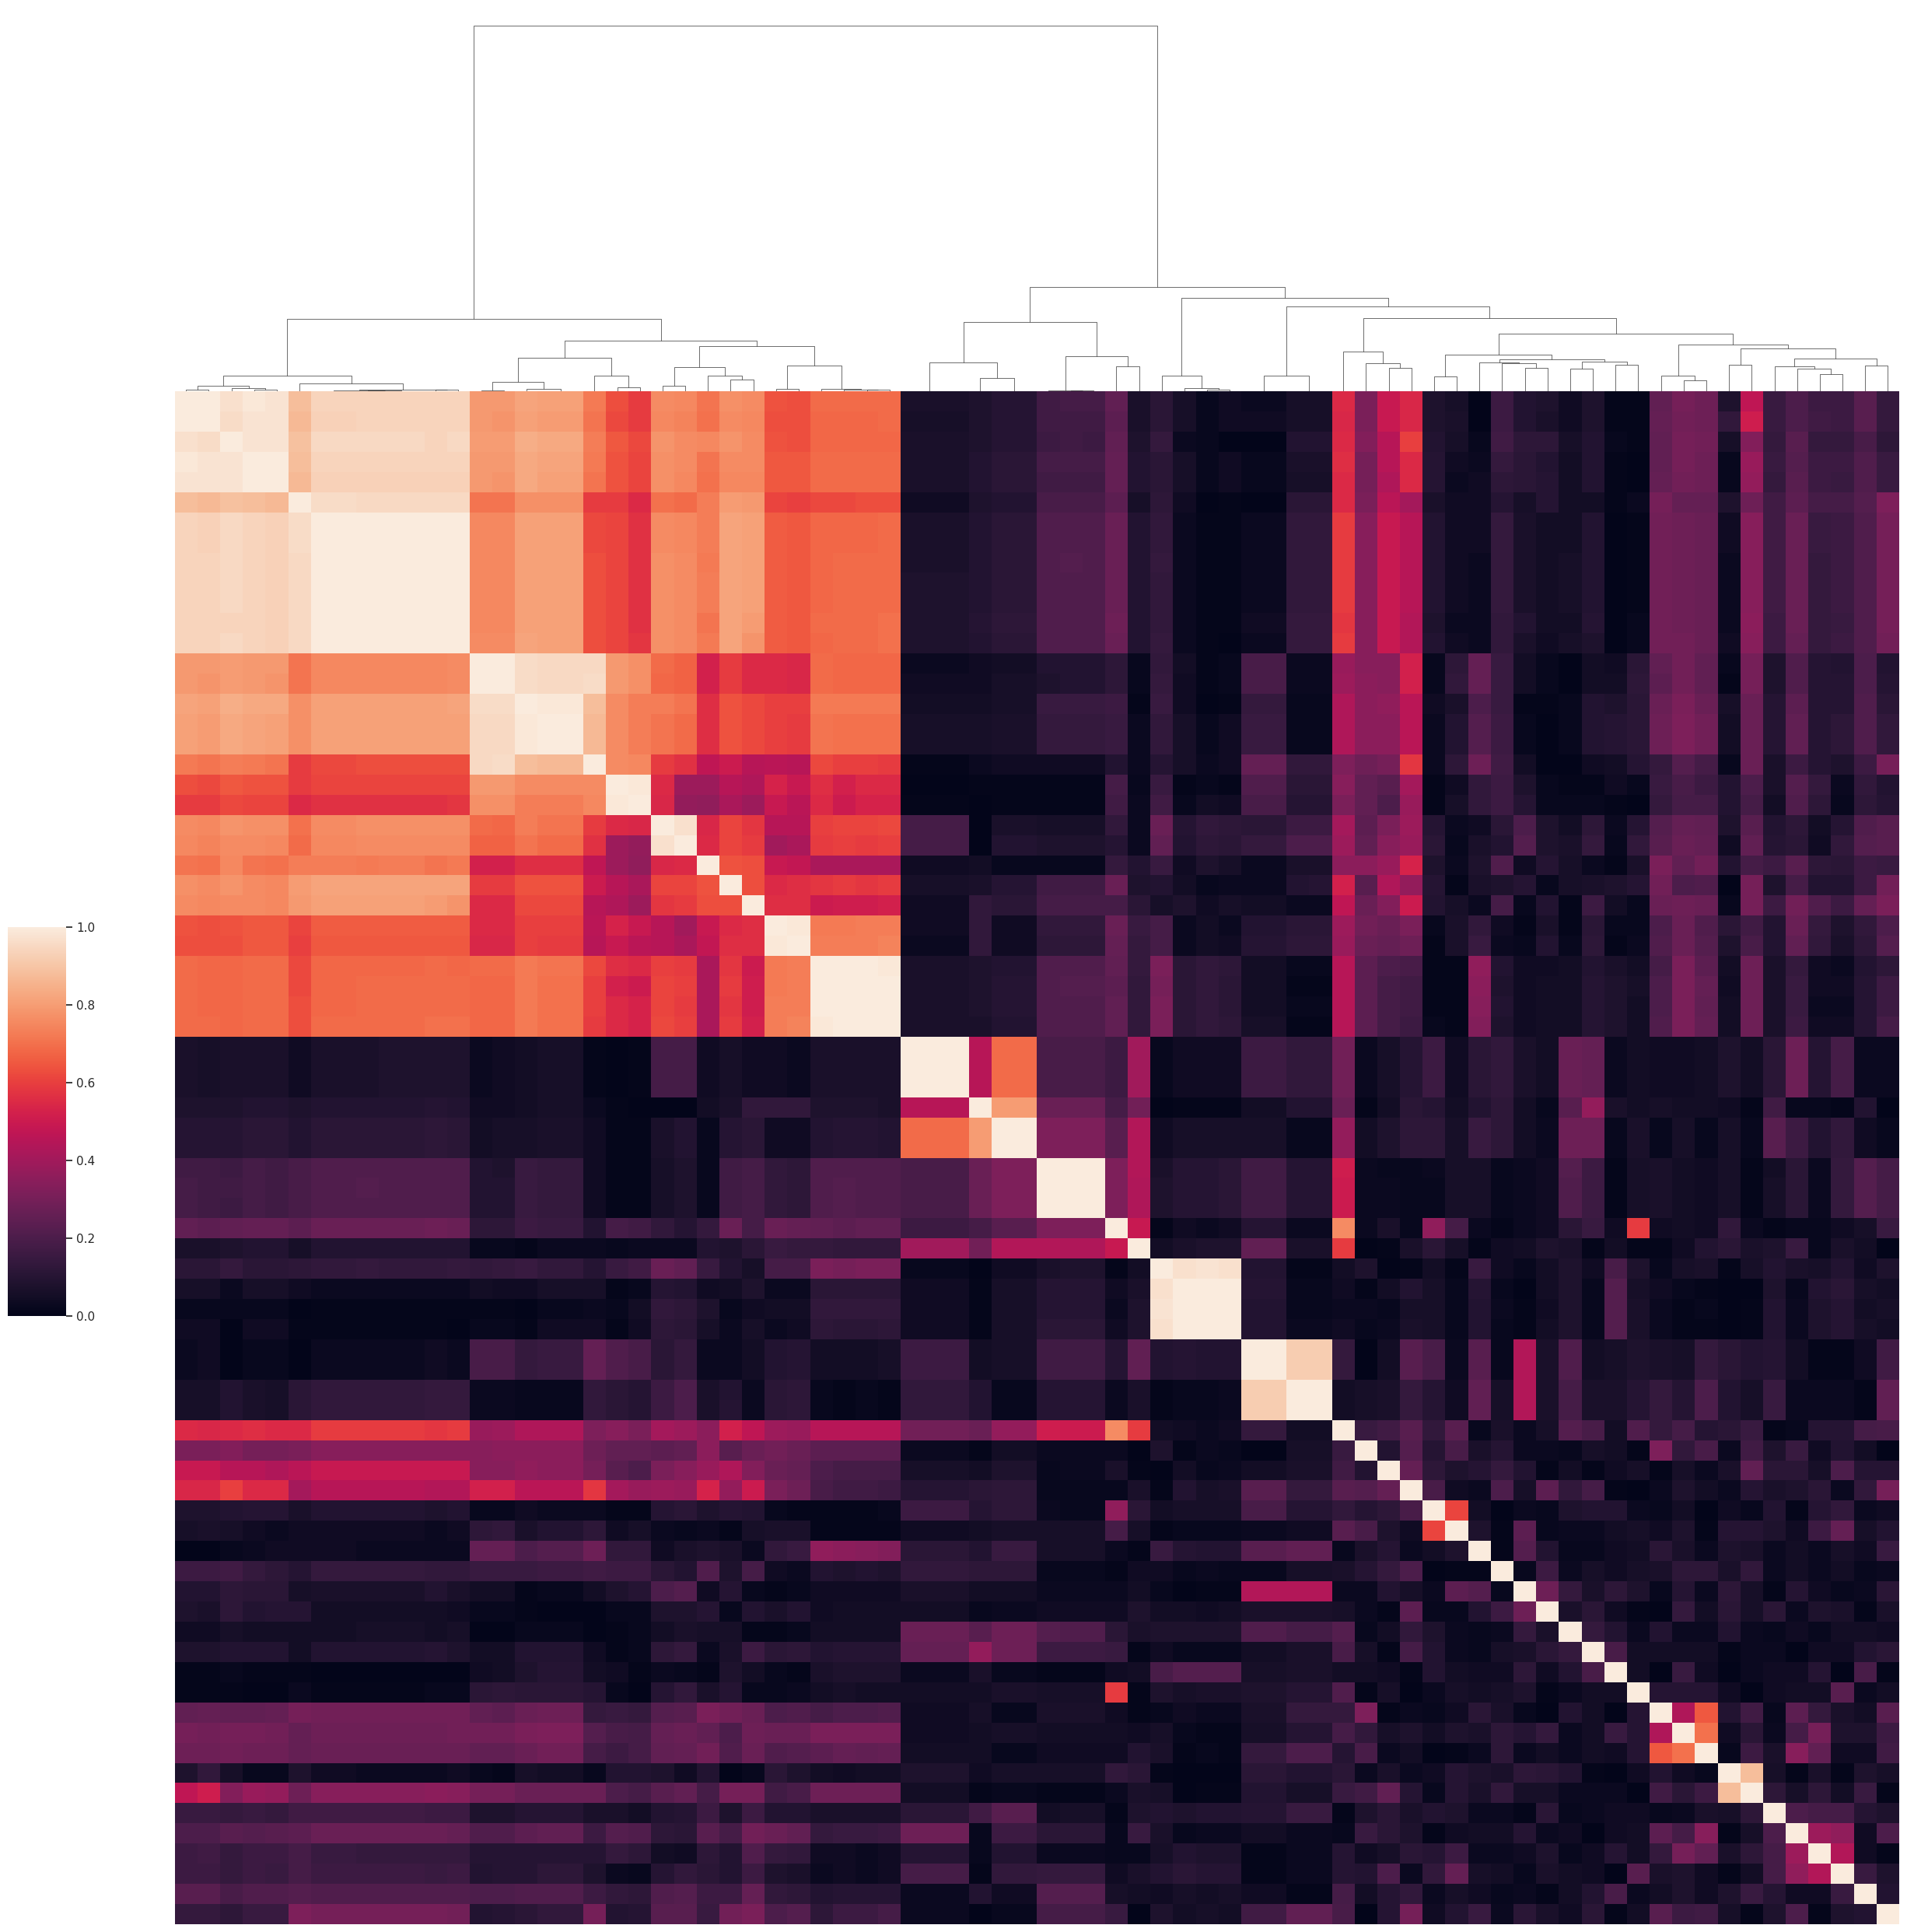

In [52]:
plot_clustermap(dataset_by_chaos, chaos_type="pod-cpu-hog", chaos_comp="carts", chaos_case_idx=0)